In [1]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys
import tensorflow as tf

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio

import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore"
                         )
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Use the correct path for the dataset directory
data = '/Users/dell/Desktop/T5/T5/The final project/T5/CUSTOM_DATASET/'

# Now use os.listdir to read the contents of the directory
dir_list = os.listdir(data)
dir_list.sort()

emotion = []
path = []
for i in dir_list:
    # Make sure to join the directory path and the subdirectory/file name
    sub_dir_path = os.path.join(data, i)
    # Check if it's a directory before attempting to list its contents
    if os.path.isdir(sub_dir_path):
        fname = os.listdir(sub_dir_path)
        for f in fname:
            # Skip system files or any files that don't match your expected format
            if f.endswith('.wav'):  # Assuming your files are .wav audio files
                part = f.split('.')[0].split('_')
                emotion.append(int(part[0]))
                file_path = os.path.join(sub_dir_path, f)
                path.append(file_path)

In [4]:
path

['/Users/dell/Desktop/T5/T5/The final project/T5/CUSTOM_DATASET\\Speaker1\\01_01_01_01_01.wav',
 '/Users/dell/Desktop/T5/T5/The final project/T5/CUSTOM_DATASET\\Speaker1\\01_02_01_01_01.wav',
 '/Users/dell/Desktop/T5/T5/The final project/T5/CUSTOM_DATASET\\Speaker1\\01_03_01_01_01.wav',
 '/Users/dell/Desktop/T5/T5/The final project/T5/CUSTOM_DATASET\\Speaker1\\01_04_01_01_01.wav',
 '/Users/dell/Desktop/T5/T5/The final project/T5/CUSTOM_DATASET\\Speaker1\\02_01_01_01_01.wav',
 '/Users/dell/Desktop/T5/T5/The final project/T5/CUSTOM_DATASET\\Speaker1\\02_02_01_01_01.wav',
 '/Users/dell/Desktop/T5/T5/The final project/T5/CUSTOM_DATASET\\Speaker1\\02_03_01_01_01.wav',
 '/Users/dell/Desktop/T5/T5/The final project/T5/CUSTOM_DATASET\\Speaker1\\02_04_01_01_01.wav',
 '/Users/dell/Desktop/T5/T5/The final project/T5/CUSTOM_DATASET\\Speaker1\\03_01_01_01_01.wav',
 '/Users/dell/Desktop/T5/T5/The final project/T5/CUSTOM_DATASET\\Speaker1\\03_02_01_01_01.wav',
 '/Users/dell/Desktop/T5/T5/The final pr

In [3]:
def text_num_split(item):
    for index, letter in enumerate(item, 0):
        if letter.isdigit():
            return [item[:index],item[index:]]

In [4]:
dir_list = os.listdir(data)
dir_list.sort()

emotion = []
path = []
for i in dir_list:
    fname = os.listdir(data + i)
    for f in fname:
        part = f.split('.')[0].split('_')
        emotion.append(int(part[0]))
        path.append(data + i + '/' + f)

In [5]:
df = pd.DataFrame(emotion)
map_dict = {1:'angry', 2:'drunk', 3:'painful', 4:'stressful'}
df.columns = ['Emotion']
df["Emotion"] = df['Emotion'].map(map_dict)
df = pd.concat([df,pd.DataFrame(path, columns = ['path'])],axis=1)
df.Emotion.value_counts()

Emotion
angry        87
stressful    87
painful      86
drunk        78
Name: count, dtype: int64

ValueError: could not convert string to float: 'angry'

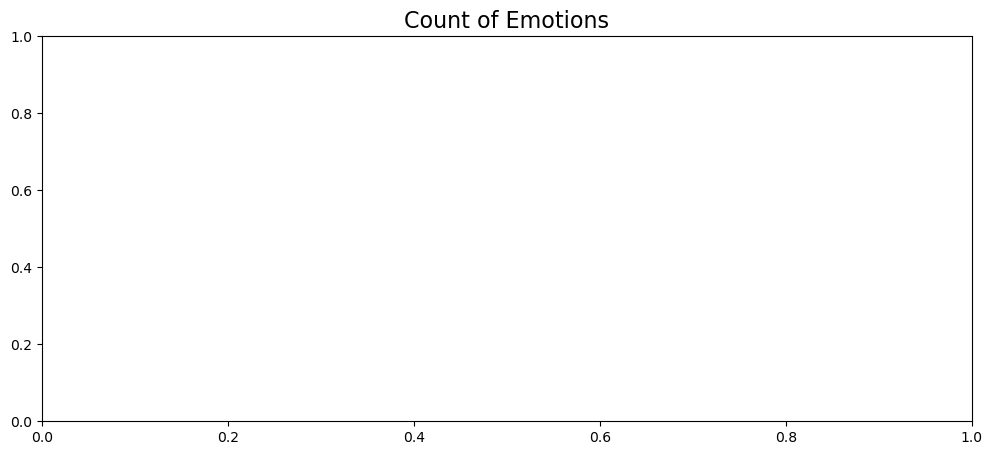

In [6]:
plt.figure(figsize=(12, 5))
plt.title('Count of Emotions', size=16)
sns.countplot(df.Emotion)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [7]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
# SHIFT 
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [8]:
# Trying different functions above
path = np.array(df['path'])[217]
data, sample_rate = librosa.load(path)

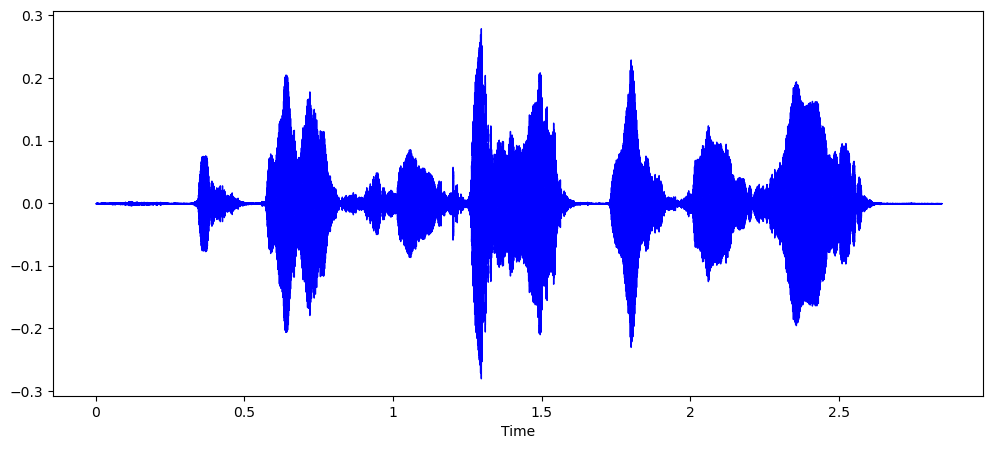

In [9]:
# NORMAL AUDIO
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sample_rate, color='b')
Audio(path)

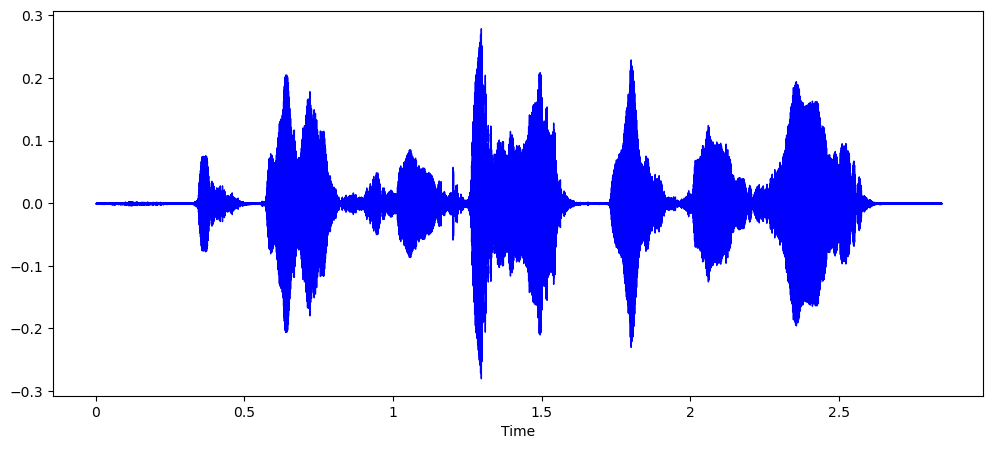

In [10]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sample_rate, color = 'b')
Audio(x, rate=sample_rate)

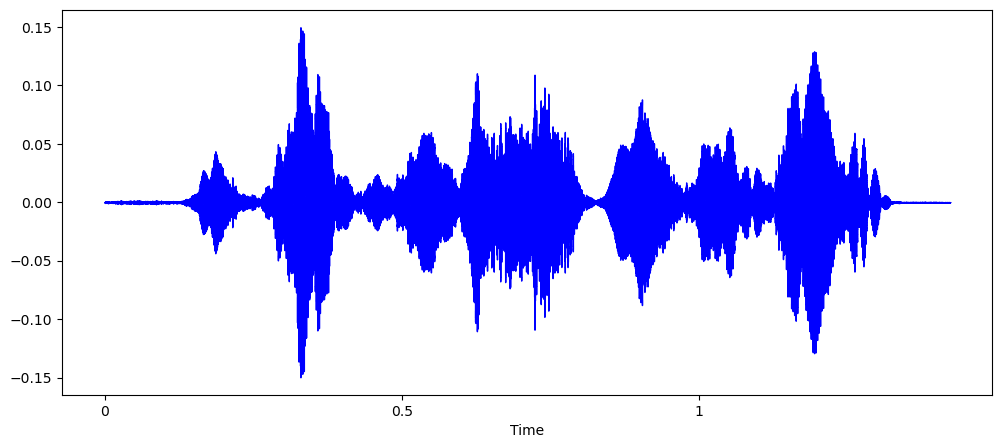

In [11]:
# Apply time stretching to the data
x = librosa.effects.time_stretch(data, rate=2.0)

# Plot the time-stretched waveform
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sample_rate, color = 'b')

# Play the time-stretched audio
Audio(x, rate=sample_rate)

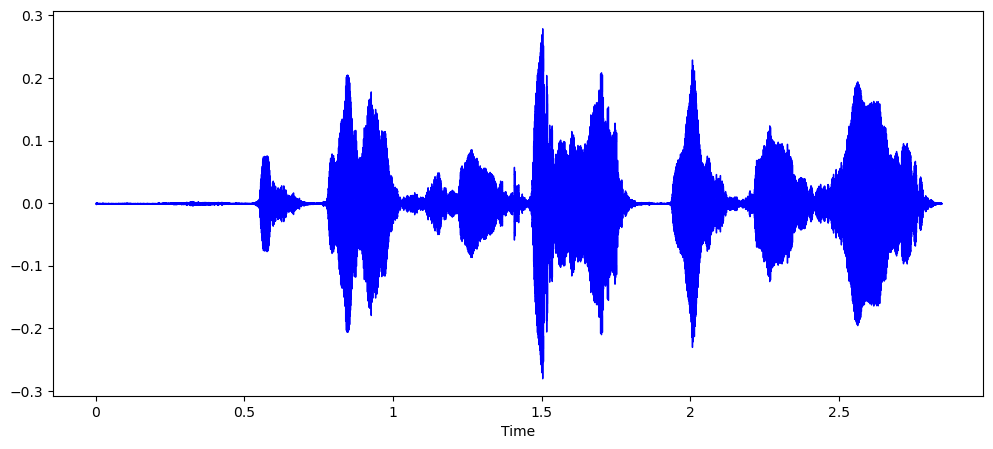

In [12]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sample_rate, color= 'b')
Audio(x, rate=sample_rate)

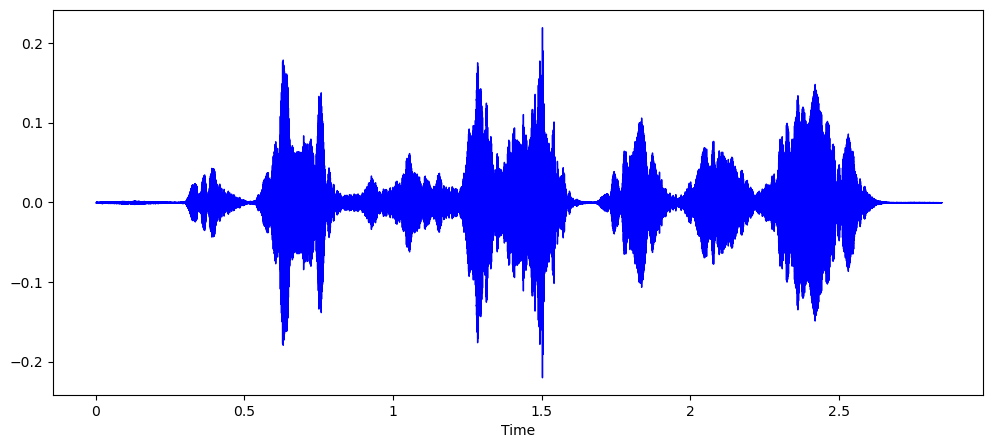

In [13]:
# AUDIO WITH PITCH
x =librosa.effects.pitch_shift(data, sr=sample_rate, n_steps=4)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sample_rate, color ='b')
Audio(x, rate=sample_rate)

In [14]:
def feat_ext(data):
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    return mfcc

def get_feat(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    # normal data
    res1 = feat_ext(data)
    result = np.array(res1)
    #data with noise
    noise_data = noise(data)
    res2 = feat_ext(noise_data)
    result = np.vstack((result, res2))
    #data with stretch and pitch
    new_data = librosa.effects.time_stretch(data, rate=2.0)
    data_stretch_pitch = librosa.effects.pitch_shift(new_data, sr=sample_rate, n_steps=4)
    res3 = feat_ext(data_stretch_pitch)
    result = np.vstack((result, res3))
    return result

In [15]:
df.head()
df['path'][0]

'/Users/dell/Desktop/T5/T5/The final project/T5/CUSTOM_DATASET/Speaker1/01_01_01_01_01.wav'

In [16]:
X, Y = [], []
for path, emotion in zip(df['path'], df['Emotion']):
    feature = get_feat(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [17]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-272.381104,132.975555,-58.297165,14.387018,-19.731339,8.232230,16.675100,-29.680996,8.486359,1.842817,...,-10.814555,-22.354412,-9.051780,-20.775711,-4.627194,8.772127,5.404399,9.879580,14.832735,angry
1,-213.353640,73.573646,-28.633902,-0.441004,-8.702955,3.448526,8.477184,-17.138362,0.775800,1.094217,...,-14.029909,-16.449664,-13.461956,-15.998769,-5.012731,8.030809,6.878398,9.705846,11.775528,angry
2,-257.086365,99.310616,-93.341949,26.099566,-39.549480,28.820595,-23.689709,-10.486879,6.975857,-35.888008,...,-16.618315,1.290055,-2.063636,19.516006,14.311628,-1.498627,11.706035,-6.599932,-1.833321,angry
3,-324.718018,149.887573,-17.795887,33.855377,-3.273965,15.846522,14.925138,-6.633803,6.166163,-4.605431,...,-7.840012,-21.723026,-1.319235,-6.773160,-18.949526,-8.675771,-9.729399,-4.259975,-7.862789,angry
4,-161.838812,35.725699,10.643489,13.703851,8.021724,4.300135,4.892397,1.910432,0.552186,-3.577449,...,-7.903059,-10.693964,-7.809343,-7.021386,-10.765127,-9.023371,-8.220404,-7.424993,-6.238568,angry


In [18]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [19]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [20]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((760, 20), (760, 4), (254, 20), (254, 4))

In [21]:
from sklearn.neighbors import KNeighborsClassifier
clf1=KNeighborsClassifier(n_neighbors=3)
clf1.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [22]:
y_pred=clf1.predict(x_test)

In [23]:
print("Training set score: {:.3f}".format(clf1.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf1.score(x_test, y_test)))

Training set score: 0.654
Test set score: 0.366


In [24]:
import xgboost as xgb

xgb_cl = xgb.XGBClassifier(n_estimators=25,objective="binary:logistic", colsample_bytree=0.8,max_depth=5,reg_lambda= 7,scale_pos_weight=3, subsample=1)

xgb_cl

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=25, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [25]:
xgb_cl.fit(x_train,y_train)

y_pred=xgb_cl.predict(x_test)
print("Training set score: {:.3f}".format(xgb_cl.score(x_train, y_train)))
print("Test set score: {:.3f}".format(xgb_cl.score(x_test, y_test)))

Training set score: 0.941
Test set score: 0.374


In [26]:
from sklearn.neural_network import MLPClassifier
clf2=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=400)
clf2.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=400)

In [27]:
y_pred=clf2.predict(x_test)

In [28]:
print("Training set score: {:.3f}".format(clf2.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf2.score(x_test, y_test)))

Training set score: 0.908
Test set score: 0.386


In [29]:
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((760, 20, 1), (760, 4), (254, 20, 1), (254, 4))

In [30]:
model = Sequential()
model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(LSTM(256, return_sequences=True))

model.add(LSTM(128))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
'''model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(4, activation='softmax'))
'''


optimiser = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001) # Here i used (tf.keras.optimizers.legacy.Adam) instead of(tf.keras.optimizers.Adam) because i run on m2 chip 
model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 2048)          12288     
                                                                 
 max_pooling1d (MaxPooling1  (None, 10, 2048)          0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 10, 2048)          8192      
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 1024)          10486784  
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 5, 1024)           0         
 g1D)                                                            
                                                        

In [32]:
history = model.fit(x_traincnn, y_train, batch_size=64, epochs=1500, validation_data=(x_testcnn, y_test))

Epoch 1/1500


12/12 [==============================] - 15s 824ms/step - loss: 1.3887 - accuracy: 0.2605 - val_loss: 1.3872 - val_accuracy: 0.2362
Epoch 2/1500
12/12 [==============================] - 9s 722ms/step - loss: 1.3801 - accuracy: 0.2882 - val_loss: 1.3879 - val_accuracy: 0.2323
Epoch 3/1500
12/12 [==============================] - 8s 713ms/step - loss: 1.3823 - accuracy: 0.2461 - val_loss: 1.3878 - val_accuracy: 0.2323
Epoch 4/1500
12/12 [==============================] - 9s 716ms/step - loss: 1.3741 - accuracy: 0.2645 - val_loss: 1.3856 - val_accuracy: 0.2913
Epoch 5/1500
12/12 [==============================] - 9s 723ms/step - loss: 1.3694 - accuracy: 0.2803 - val_loss: 1.3860 - val_accuracy: 0.2244
Epoch 6/1500
12/12 [==============================] - 9s 772ms/step - loss: 1.3604 - accuracy: 0.2895 - val_loss: 1.3845 - val_accuracy: 0.2441
Epoch 7/1500
12/12 [==============================] - 9s 788ms/step - loss: 1.3567 - accuracy: 0.2803 - val_loss: 1.3819 - val_accura

In [36]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

8/8 [==============================] - 1s 85ms/step - loss: 4.6453 - accuracy: 0.5512
Accuracy of our model on test data :  55.11810779571533 %


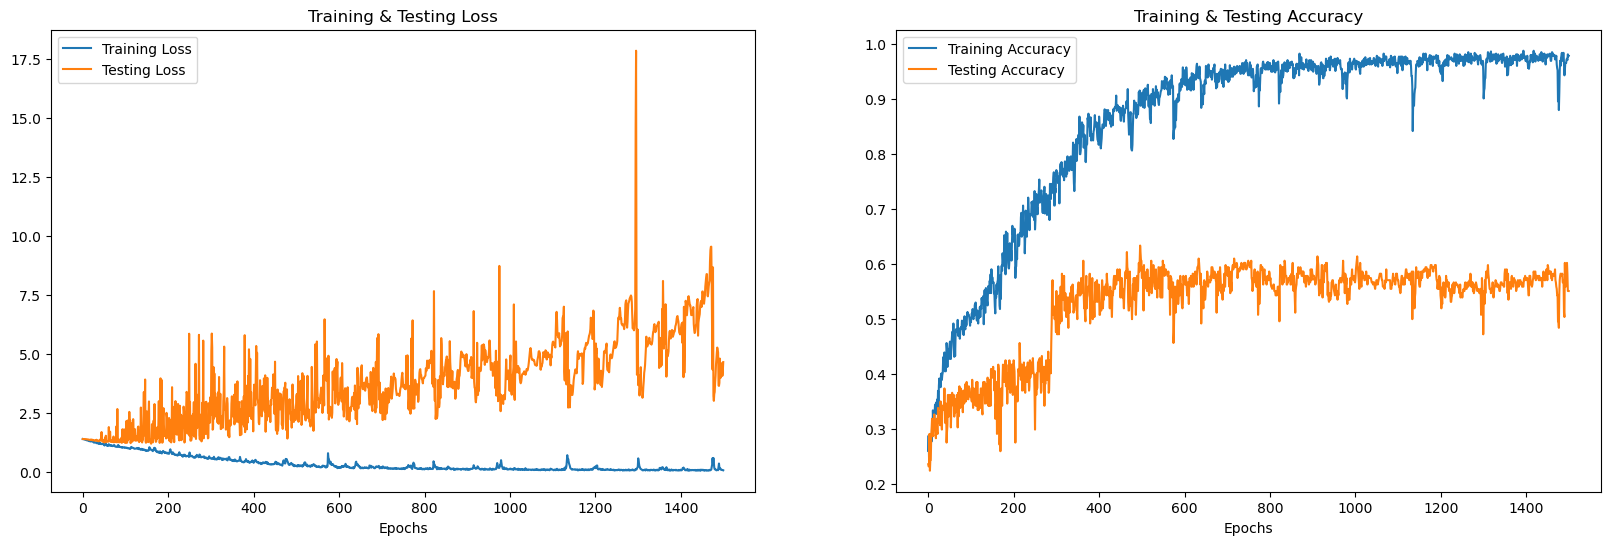

In [37]:
epochs = [i for i in range(1500)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [38]:
pred_test = model.predict(x_testcnn)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(100)

8/8 [==============================] - 2s 86ms/step


,Predicted Labels,Actual Labels
0,painful,painful
1,drunk,drunk
2,painful,painful
3,stressful,stressful
4,drunk,drunk
...,...,...
95,drunk,drunk
96,painful,drunk
97,painful,drunk
98,stressful,stressful


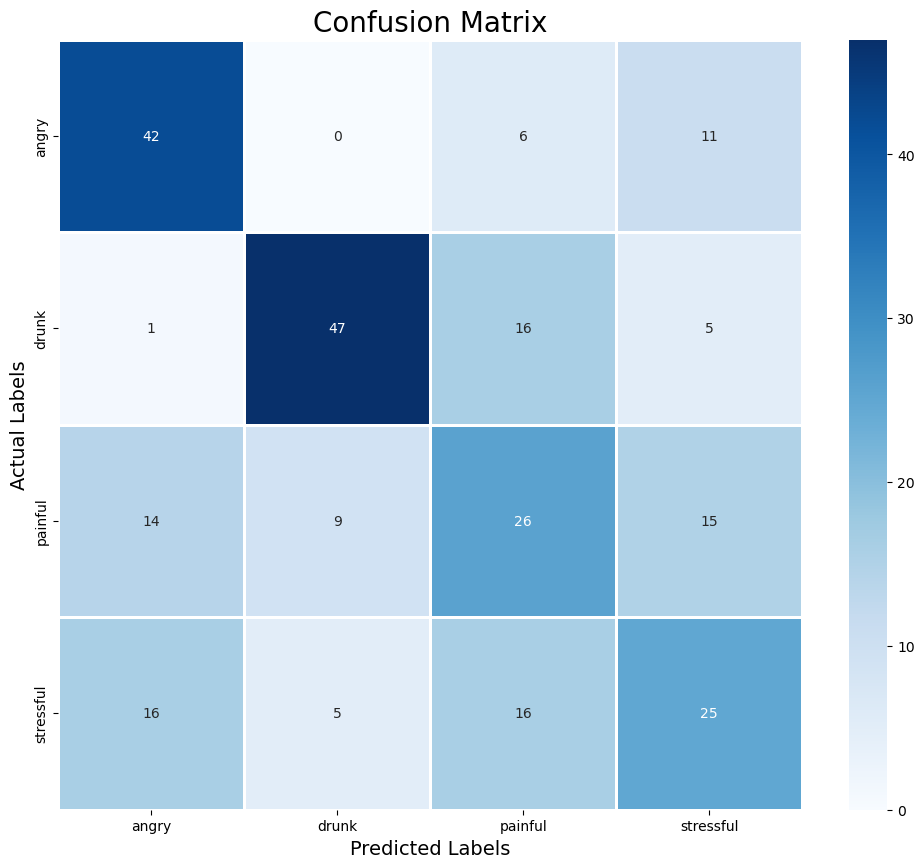

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [40]:
model_name = 'Emotion_Emergency.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\dell\Desktop\T5\T5\The final project\T5\saved_models\Emotion_Emergency.h5 


In [41]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [42]:
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/Users/dell/Desktop/T5/T5/The final project/T5/saved_models\Emotion_Emergency.h5")
print("Loaded model from disk")

Loaded model from disk


In [48]:
data, sampling_rate = librosa.load('/Users/dell/Desktop/T5/T5/The final project/T5/CUSTOM_DATASET/Speaker3/01_01_01_01_03.wav')

In [49]:
sample = "/Users/dell/Desktop/T5/T5/The final project/T5/CUSTOM_DATASET/Speaker3/01_01_01_01_03.wav"
feature = get_feat(sample)
test =np.expand_dims(feature, axis=2)
livepreds = loaded_model.predict(test)
livepredictions = (encoder.inverse_transform((livepreds)))
livepredictions

1/1 [==============================] - 1s 1s/step


array([['angry'],
       ['stressful'],
       ['angry']], dtype=object)